In [2]:
import pandas as pd
DATA_PATH="/content/HIV.csv"
data=pd.read_csv(DATA_PATH)

In [3]:
data.head()

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


In [4]:
print(data.shape)

(41127, 3)


In [5]:
print(data["HIV_active"].value_counts())

0    39684
1     1443
Name: HIV_active, dtype: int64


In [6]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 35.3 MB/s eta 0:00:00


In [7]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

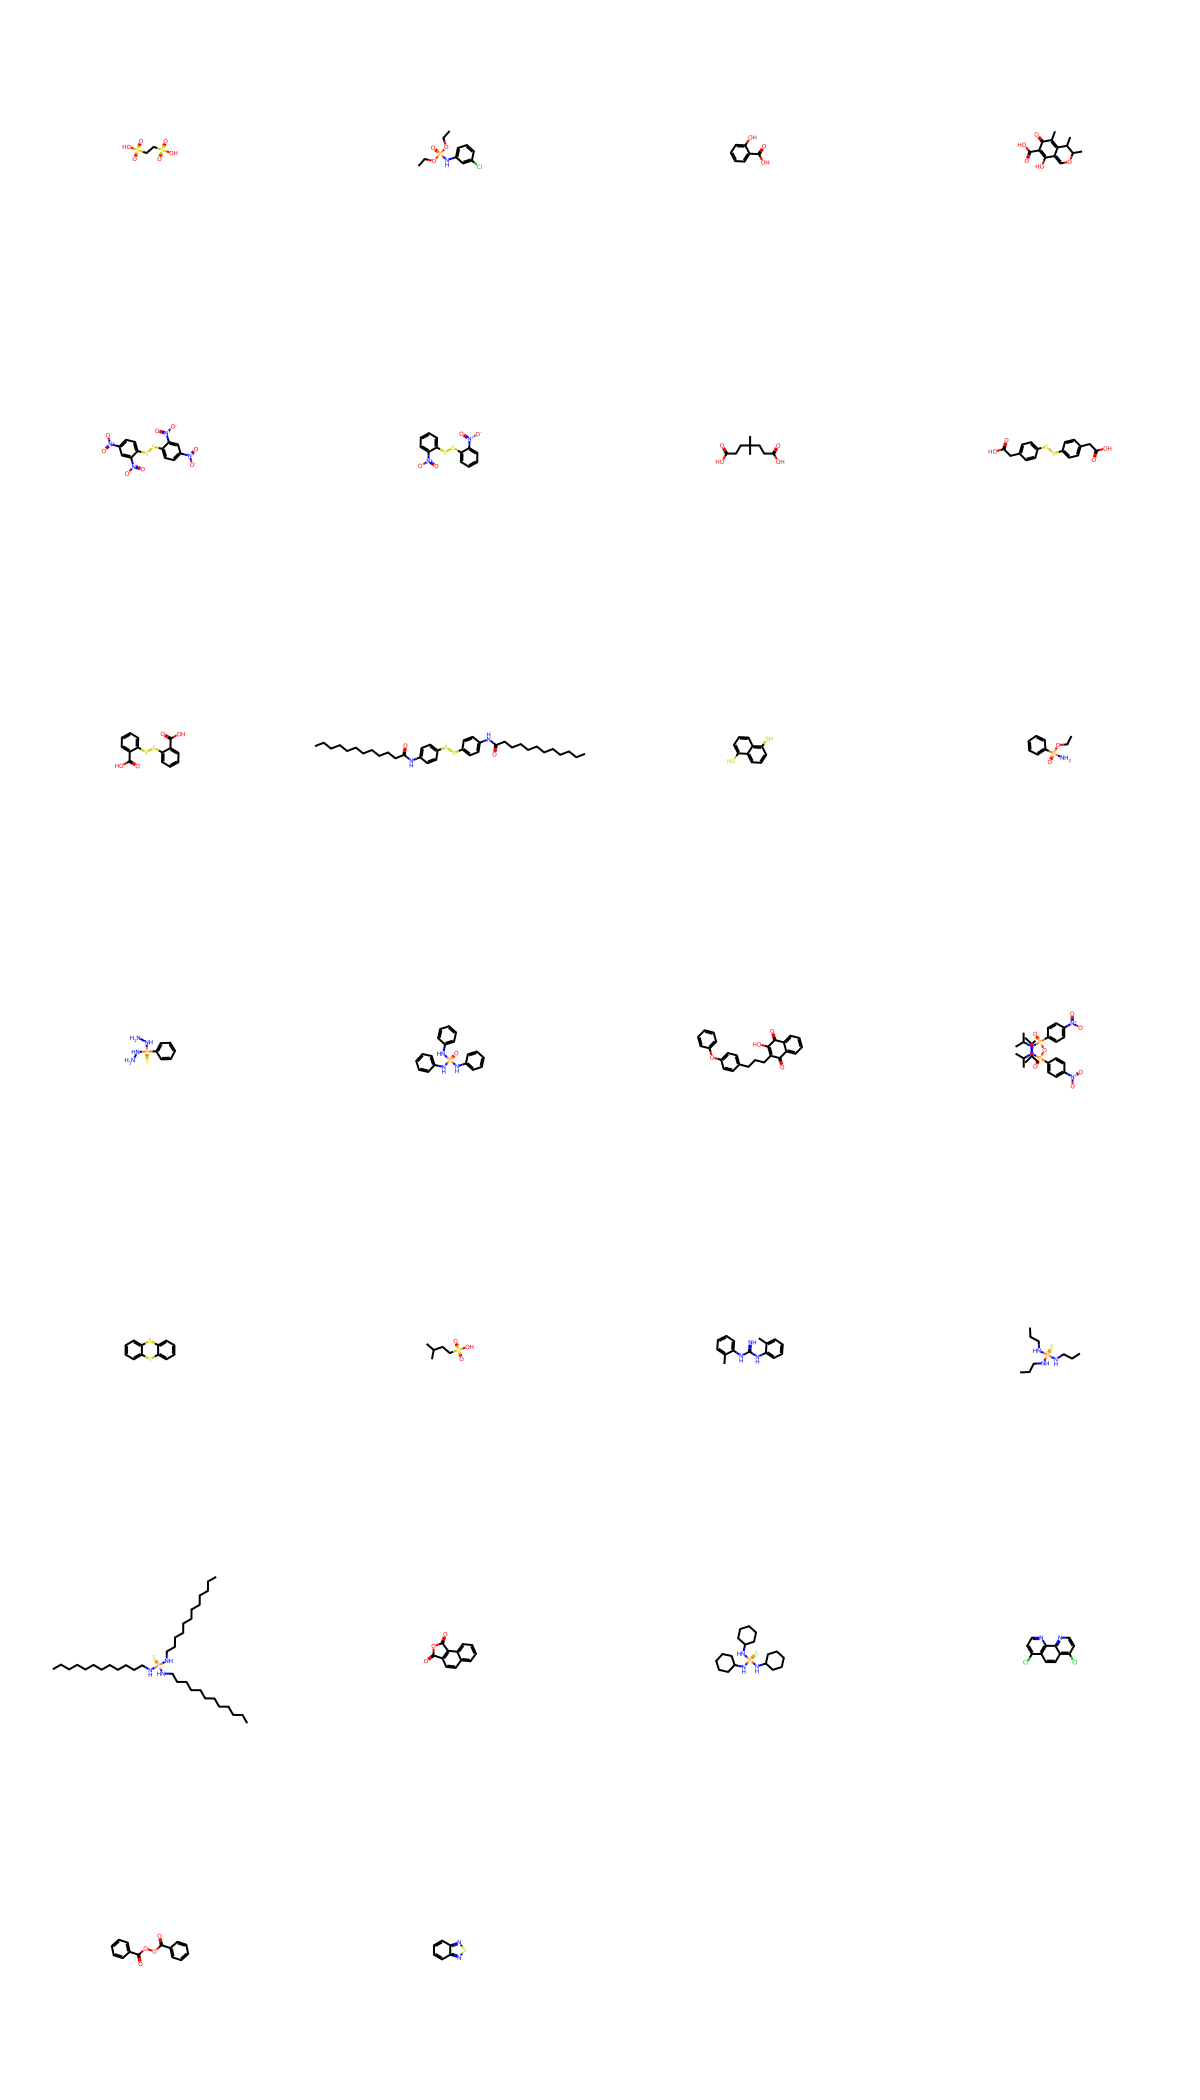

In [8]:
sample_smiles=data["smiles"][4:30].values
sample_mols=[Chem.MolFromSmiles(smiles) for \
             smiles in sample_smiles]
grid=Draw.MolsToGridImage(sample_mols,molsPerRow=4,subImgSize=(300,300))
grid

Generate a DataSet

In [9]:
import torch
!pip install torch-geometric
from torch_geometric.data import Dataset,Data
import numpy as np
import os
from rdkit.Chem import rdmolops
from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.3 MB/s eta 0:00:00


In [27]:
class MoleculeDataset(Dataset):
    def __init__(self, root, filename,transform=None, pre_transform=None, test=False):
        self.test = test
        self.filename = "HIV_train_oversampled (2).csv"
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)

    def raw_file_names(self):
        return [self.filename]

    def download(self):
        pass

    def processed_file_names(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in range(len(self.data))]
        else:
            return [f'data_{i}.pt' for i in range(len(self.data))]

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0])
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            mol_obj = Chem.MolFromSmiles(mol["smiles"])
            node_feats = self._get_node_features(mol_obj)
            edge_feats = self._get_edge_features(mol_obj)
            edge_index = self._get_adjacency_info(mol_obj)
            label = self._get_labels(mol["HIV_active"])

            data = Data(x=node_feats, edge_index=edge_index, edge_attr=edge_feats, y=label, smiles=mol["smiles"])
            if self.test:
                torch.save(data, os.path.join(self.processed_dir, f'data_test_{index}.pt'))
            else:
                torch.save(data, os.path.join(self.processed_dir, f'data_{index}.pt'))

    def _get_node_features(self, mol):
        all_node_feats = []
        for atom in mol.GetAtoms():
            node_feats = []
            node_feats.append(atom.GetAtomicNum())  # Atomic Number
            node_feats.append(atom.GetDegree())     # Atom degree
            node_feats.append(atom.GetFormalCharge())  # Formal Charge
            node_feats.append(atom.GetHybridization())  # Hybridization
            node_feats.append(atom.GetIsAromatic())    # Aromaticity
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        all_edge_feats = []
        for bond in mol.GetBonds():
            edge_feats = []
            edge_feats.append(bond.GetBondTypeAsDouble())  # Bond Type
            edge_feats.append(bond.IsInRing())            # Rings
            all_edge_feats.append(edge_feats)

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def _get_adjacency_info(self, mol):
        adj_matrix = rdmolops.GetAdjacencyMatrix(mol)
        row, col = np.where(adj_matrix)
        coo = np.array(list(zip(row, col)))
        coo = np.reshape(coo, (2, -1))
        return torch.tensor(coo, dtype=torch.long)

    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return len(self.data)

    def get(self, idx):
      if self.test:
        file_path = os.path.join(self.processed_dir, f'data_test_{idx}.pt')
      else:
        file_path = os.path.join(self.processed_dir, f'data_{idx}.pt')

      if os.path.exists(file_path):
        data = torch.load(file_path)
        return data
      else:
        raise FileNotFoundError(f"File {file_path} not found.")



In [28]:
# Instantiate the dataset
dataset = MoleculeDataset(root="/content/data/",filename="HIV_train_oversampled (2).csv")

# Print the first element in the dataset
print(dataset[0])

# Alternatively, if you want to print specific attributes of the data
data = dataset[0]
print("Node features:", data.x)
print("Edge features:", data.edge_attr)


Data(x=[75, 5], edge_index=[2, 162], edge_attr=[81, 2], y=[1], smiles='O=C(Nc1ccc(C=Cc2ccc(NC(=O)c3ccc(N=Nc4cc(S(=O)(=O)O)c5cccnc5c4O)cc3)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1)c1ccc(N=Nc2cc(S(=O)(=O)O)c3cccnc3c2O)cc1.[NaH]')
Node features: tensor([[ 8.,  1.,  0.,  3.,  0.],
        [ 6.,  3.,  0.,  3.,  0.],
        [ 7.,  2.,  0.,  3.,  0.],
        [ 6.,  3.,  0.,  3.,  1.],
        [ 6.,  2.,  0.,  3.,  1.],
        [ 6.,  2.,  0.,  3.,  1.],
        [ 6.,  3.,  0.,  3.,  1.],
        [ 6.,  2.,  0.,  3.,  0.],
        [ 6.,  2.,  0.,  3.,  0.],
        [ 6.,  3.,  0.,  3.,  1.],
        [ 6.,  2.,  0.,  3.,  1.],
        [ 6.,  2.,  0.,  3.,  1.],
        [ 6.,  3.,  0.,  3.,  1.],
        [ 7.,  2.,  0.,  3.,  0.],
        [ 6.,  3.,  0.,  3.,  0.],
        [ 8.,  1.,  0.,  3.,  0.],
        [ 6.,  3.,  0.,  3.,  1.],
        [ 6.,  2.,  0.,  3.,  1.],
        [ 6.,  2.,  0.,  3.,  1.],
        [ 6.,  3.,  0.,  3.,  1.],
        [ 7.,  2.,  0.,  3.,  0.],
        [ 7.,  2.,  0.,  3.,  0.]

Data Featurizer

In [29]:
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear,BatchNorm1d,ReLU
from torch_geometric.nn import TransformerConv,GATConv,TopKPooling,BatchNorm
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn.conv.x_conv import XConv


In [65]:
class GNN(torch.nn.Module):
  def __init__(self,feature_size):
    super(GNN,self).__init__()
    num_classes=2
    embedding_size=1024
    #embedding size-->feature size of the every node
    #num_classes means the number of the things i can divide into
    #GNN is the super class
    #feature size is the input feature size

    #GNN Layers
    self.conv1=GATConv(feature_size, embedding_size,heads=3,dropout=0.3)
    #GCN is formed by the message passing and weights are calculated by the number fo degress
    #GAT is formed by the message paasing but the weights are calculated by the embeddings only
    #NUmber of dropouts is the numbe rof droped test cases
    #number of the heads is the number of different weights i used to get the different layers
    self.head_transform1=Linear(embedding_size*3, embedding_size)
    #it performs the linear transform
    #from the 3* embedding size[size of the input vector]--> emebedding size
    self.pool1=TopKPooling(embedding_size,ratio=0.8)
    #it is the pooling from all the nodes
    #first it makes a vector consiting of all the nodes then it takes the top 80 percent nodes, and they only remain in graph
    self.conv2=GATConv(embedding_size,embedding_size,heads=3,dropout=0.3)
    self.head_transform2=Linear(embedding_size*3,embedding_size)
    self.pool2=TopKPooling(embedding_size,ratio=0.5)
    self.conv3=GATConv(embedding_size,embedding_size,heads=3,dropout=0.3)
    self.head_transform3=Linear(embedding_size*3,embedding_size)
    self.pool3=TopKPooling(embedding_size,ratio=0.2)

    #Linear Layers
    self.linear1=Linear(embedding_size*2,1024)
    self.linear2=Linear(1024,num_classes)
    #The GNN Layers calculates the Node embedding and the pooling of the nodes.
    #Linear layers calculates the results of classification from the embeddings.

  def forward(self,x,edge_attr,edge_index,batch_index):
      x=self.conv1(x,edge_index)
      #as the message passing will need the edge index also
      #as the x is the [num_nodes, num_features(5)]
      #x is changed to 3* embedding size
      x=self.head_transform1(x)
      #now the x is changes to the num_nodes*embedding size
      x,edge_index, edge_attr,batch_index, _, _=self.pool1(x,edge_index,None,batch_index)
      #bro give the new graph new x [0.8 num nodes* embedding size]
      #so the new edges have to formed
      #batch_index is ofcourse new batches have to formed
      x1=torch.cat([gmp(x,batch_index),gap(x,batch_index)],dim=1)
      #gmp-global mean pool
      #gap-global max pool
      #it becomes the embedding *2 x1 size
      #I will calculate this after every layer
      x=self.conv2(x,edge_index)
      x=self.head_transform2(x)
      x,edge_index,edge_attr,batch_index, _, _=self.pool2(x,edge_index,None,batch_index)
      x2=torch.cat([gmp(x,batch_index),gap(x,batch_index)],dim=1)
      x=self.conv3(x,edge_index)
      x=self.head_transform3(x)
      x,edge_index,edge_attr,batch_index, _, _=self.pool3(x,edge_index,None,batch_index)
      x3=torch.cat([gmp(x,batch_index),gap(x,batch_index)],dim=1)
      x=x1+x2+x3
      #i concatenated the all 3 results
      x=self.linear1(x).relu()
      #this changes the size from 2*embedding size to 1024
      x=self.linear2(x)
      return x;

Training the Model

In [66]:
#imports
import torch
from torch_geometric.data import DataLoader
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,precision_score,recall_score,roc_auc_score
import numpy as np
from tqdm import tqdm
!pip install mlflow
import mlflow.pytorch



In [67]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# it set ups the storage device
def count_parameters(model):
  return sum(p.numel() for p in list(model.parameters()))
  # p is the parameters of the GNN Model
  # p is a tensor
  # .numel() actually calculates the size of that vector

train_dataset= MoleculeDataset(root="data/", filename="HIV_train_oversampled (2).csv")
test_dataset=MoleculeDataset(root="data/", filename="HIV_test (2).csv")
#we actually divide the dataset into the test and train

#Learning the model
model=GNN(feature_size=train_dataset[0].x.shape[1])
#it is just giving the 5
print(train_dataset[0])
# the one example of the dataset contain the whole graph
#5 features of the all the node that it have
print(train_dataset[0].x)
# it contains approx 74 nodes with 5 features of all
print(train_dataset[0].x.shape[1])
# it will give the shape of the x
print(train_dataset[0].x.shape[0])
# it will give the column (the number of the nodes of the x)

model=model.to(device)
print("number of the paramaters")
print(count_parameters(model))

Data(x=[75, 5], edge_index=[2, 162], edge_attr=[81, 2], y=[1], smiles='O=C(Nc1ccc(C=Cc2ccc(NC(=O)c3ccc(N=Nc4cc(S(=O)(=O)O)c5cccnc5c4O)cc3)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1)c1ccc(N=Nc2cc(S(=O)(=O)O)c3cccnc3c2O)cc1.[NaH]')
tensor([[ 8.,  1.,  0.,  3.,  0.],
        [ 6.,  3.,  0.,  3.,  0.],
        [ 7.,  2.,  0.,  3.,  0.],
        [ 6.,  3.,  0.,  3.,  1.],
        [ 6.,  2.,  0.,  3.,  1.],
        [ 6.,  2.,  0.,  3.,  1.],
        [ 6.,  3.,  0.,  3.,  1.],
        [ 6.,  2.,  0.,  3.,  0.],
        [ 6.,  2.,  0.,  3.,  0.],
        [ 6.,  3.,  0.,  3.,  1.],
        [ 6.,  2.,  0.,  3.,  1.],
        [ 6.,  2.,  0.,  3.,  1.],
        [ 6.,  3.,  0.,  3.,  1.],
        [ 7.,  2.,  0.,  3.,  0.],
        [ 6.,  3.,  0.,  3.,  0.],
        [ 8.,  1.,  0.,  3.,  0.],
        [ 6.,  3.,  0.,  3.,  1.],
        [ 6.,  2.,  0.,  3.,  1.],
        [ 6.,  2.,  0.,  3.,  1.],
        [ 6.,  3.,  0.,  3.,  1.],
        [ 7.,  2.,  0.,  3.,  0.],
        [ 7.,  2.,  0.,  3.,  0.],
        [ 6.,

In [68]:
model
# it is simply the summary of my model

GNN(
  (conv1): GATConv(5, 1024, heads=3)
  (head_transform1): Linear(in_features=3072, out_features=1024, bias=True)
  (pool1): TopKPooling(1024, ratio=0.8, multiplier=1.0)
  (conv2): GATConv(1024, 1024, heads=3)
  (head_transform2): Linear(in_features=3072, out_features=1024, bias=True)
  (pool2): TopKPooling(1024, ratio=0.5, multiplier=1.0)
  (conv3): GATConv(1024, 1024, heads=3)
  (head_transform3): Linear(in_features=3072, out_features=1024, bias=True)
  (pool3): TopKPooling(1024, ratio=0.2, multiplier=1.0)
  (linear1): Linear(in_features=2048, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=2, bias=True)
)

In [69]:
#Loss and Optimizer
weights=torch.tensor([1,10],dtype=torch.float32).to(device)
#wieghts here represent the one dimensional vector contains element 1,10
#it may be the wiehgts for the two class
loss_fn=torch.nn.CrossEntropyLoss(weight=weights)
#it mailnly focuses on the positive value
optimizer=torch.optim.SGD(model.parameters(),lr=0.1,momentum=0.9)
# it optimize the parametrs means uses the gradient descent
#Learning rate is 0.1
scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.95)
#this smoothly changes the learning rate during the gradient descent

In [70]:
#Classical Batch Training
NUM_GRAPHS_PER_BATCH=256
#graphs per batch is actually 256
train_loader=DataLoader(train_dataset,batch_size=NUM_GRAPHS_PER_BATCH,shuffle=True)
# it provides the randomized 256 datset points , everytime it provides different batch points and shuffling is there
test_loader=DataLoader(test_dataset,batch_size=NUM_GRAPHS_PER_BATCH,shuffle=True)
# it provides the randomized 256 datset points , everytime it provides different batch points and shuffling is there
def train(epoch):
  all_preds=[]
  # they are the predictions done by our model
  all_labels=[]
  # they are the real results of our model
  for _,batch in enumerate(tqdm(train_loader)):
    #this line enumerates on the batches of the train loader
    #tqdm just creates a progress bar for the batch we are running on
    #_, is the variable that we are not using in that loop
    batch.to(device)
    #batch get transfered to the device
    pred=model(batch.x.float(),batch.edge_attr.float(),batch.edge_index,batch.batch)
    #model internally runs the forward function parallerly on the all the inputs graphs of the batch
    #forward function calculates the pred of the different graphs parallely
    loss=torch.sqrt(loss_fn(pred,batch.y))
    all_preds.append(np.argmax(pred.cpu().detach().numpy(),axis=1))
    #it is taking the maximum along the second axis of the pred means the pred contain the 2 elements as max and mean pool
    #.cpu takes the gpu to cpu
    #it detaches the gradient from the torch
    #.numpy() changes it to the numpy array
    all_labels.append(np.argmax(batch.y.cpu().detach().numpy()))
    #it inserts the labels of the batch to the final label array
  all_preds=np.concatenate(all_preds).ravel()
  all_label=np.concatenate(all_labels).ravel()
  # all preds was before the list of the list but now it is actually a flattened list
  calculate_metrics(all_preds,all_labels,epoch,"train")
  #it calculates the parameters related during our training process
  return loss

def calculate_metrics(y_pred,y_true,epoch,type):
  print("confusion_matrix")
  print(confusion_matrix(y_pred,y_true))
  #it is the matrix with four cells that account for the true positive , false positive , true negative and false negative
  print("F1 Score")
  #it is the harmonic mean of the recall and precision
  print(f1_score(y_pred,y_true))
  print("Accuracy")
  #correctly predicted by the total observation
  print(accuracy_score(y_pred,y_true))
  print("Precision")
  #corrected predicted positive / total predicted positives
  print(precision_score(y_pred,y_true))
  print("Recall")
  #correctly positive / real positive
  print(recall_score(y_pred,y_ture))

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Run the Training

In [ ]:
with mlflow.start_run() as run:
  for epoch in range (500):
    # the whole dataset is runned 500 times
    model.train()
    loss=train(epoch==epoch)
    loss=loss.detach().cpu().numpy()
    # again the loss is taken from the training function and
    # it is detached from its derivate taken to cpu and converted to numpy
    print(f"epoch {epoch} train_loss {loss}")
    mlflow.log_metric(key=="Train loss",value=float(value),step=epoch)

    model.eval()
    if epoch%5==0:
      loss=test(epoch==epoch)
      loss=loss.detach().cpu().numpy()
      print(f"epoch {epoch} test_loss {loss}")
      mlflow.log_metric(key=="Test loss",value=float(value),step=epoch)
      try:
        roc = roc_auc_score(y_true, y_pred)
        print(f"ROC AUC: {roc}")
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(roc), step=epoch)
      except:
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(0), step=epoch)
        print(f"ROC AUC: notdefined")
    scheduler.step()
  print("Done.")

 32%|███▎      | 91/280 [06:47<13:30,  4.29s/it]